In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline 

plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams['image.interpolation'] = 'nearest'         
plt.rcParams['image.cmap'] = 'gray'


In [2]:
import sys
caffe_root = '/Users/Bato/Documents/caffe/'
sys.path.insert(0, caffe_root+'python')

import caffe


/Users/Bato/Documents/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/Users/Bato/Documents/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/Users/Bato/Documents/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


In [3]:
caffe.set_mode_cpu()

model_def = caffe_root + 'models/fine_tune_CaffeNet/Tune_fc78_1500iters/test2_4/deploy.prototxt'
model_weight = caffe_root + 'models/fine_tune_CaffeNet/Tune_fc78_1500iters/test2_4/caffenet_train_iter_1500.caffemodel'

net = caffe.Net(model_def, model_weight, caffe.TEST)


Set up input preprocessing. (We'll use Caffe's caffe.io.Transformer to do this, but this step is independent of other parts of Caffe, so any custom preprocessing code may be used).

Our default CaffeNet is configured to take images in BGR format. Values are expected to start in the range [0, 255] and then have the mean ImageNet pixel value subtracted from them. In addition, the channel dimension is expected as the first (outermost) dimension.

As matplotlib will load images with values in the range [0, 1] in RGB format with the channel as the innermost dimension, we are arranging for the needed transformations here.

In [4]:
# set the size of input
net.blobs['data'].reshape(50,        # batch size 
                        3,          # 3-channel(BGR) images
                        227, 227)   # image size


In [5]:
mu = np.load(caffe_root+'python/caffe/imagenet/ilsvrc_2012_mean.npy') # mu:(3, 256, 256)
mu = mu.mean(1).mean(1) # Obtain the mean (BGR) pixel values
# print 'mean-substracted values:',zip('BGR',mu)

transformer = caffe.io.Transformer({'data':net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR


In [6]:
image = caffe.io.load_image(caffe_root + 'examples/images/cat.jpg')
transformed_image = transformer.preprocess('data',image)
# plt.imshow(image)
# plt.grid('off')


In [7]:
net.blobs['data'].data[...] = transformed_image

output = net.forward()

output_prob = output['prob'][0]

print 'predicted class is:',output_prob.argmax()


predicted class is: 0


In [8]:
labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
labels = np.loadtxt(labels_file, str, delimiter='\t')
print 'output label:',labels[output_prob.argmax()]


output label: n01440764 tench, Tinca tinca


In [9]:
top_inds = output_prob.argsort()[::-1][:5]

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])


probabilities and labels:


[(0.99999046, 'n01440764 tench, Tinca tinca'),
 (9.574238e-06, 'n01443537 goldfish, Carassius auratus')]

In [18]:
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)
    

data	(50, 3, 227, 227)
conv1	(50, 96, 55, 55)
pool1	(50, 96, 27, 27)
norm1	(50, 96, 27, 27)
conv2	(50, 256, 27, 27)
pool2	(50, 256, 13, 13)
norm2	(50, 256, 13, 13)
conv3	(50, 384, 13, 13)
conv4	(50, 384, 13, 13)
conv5	(50, 256, 13, 13)
pool5	(50, 256, 6, 6)
fc6	(50, 4096)
fc7_tune	(50, 4096)
fc8_tune	(50, 2)
prob	(50, 2)


In [19]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)
    

conv1	(96, 3, 11, 11) (96,)
conv2	(256, 48, 5, 5) (256,)
conv3	(384, 256, 3, 3) (384,)
conv4	(384, 192, 3, 3) (384,)
conv5	(256, 192, 3, 3) (256,)
fc6	(4096, 9216) (4096,)
fc7_tune	(4096, 4096) (4096,)
fc8_tune	(2, 4096) (2,)


In [3]:
def vis_square(data):
    data = (data - data.min())/(data.max() - data.min())
    
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n**2 - data.shape[0]), (0, 1), (0, 1)) + ((0, 0),) * (data.ndim - 3))
    data = np.pad(data, padding, mode = 'constant', constant_values=1)
    
    data = data.reshape((n, n) + data.shape[1:]).transpose((0,2,1,3)+tuple(range(4, data.ndim+1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')
    

In [228]:
# filters = net.params['conv1'][0].data
# vis_square(filters.transpose(0, 2, 3, 1))

# feat = net.blobs['pool5'].data[0, :]
# vis_square(feat)


In [2]:
import scipy.io as scio
Data = scio.loadmat('/Users/Bato/Dropbox/tsne_python_5.25/All_PC_DataforBato.mat')
I = Data['images']; Ans = Data['state'] # shape of I: (101, 101, 842), shape of Ans:(1, 842)


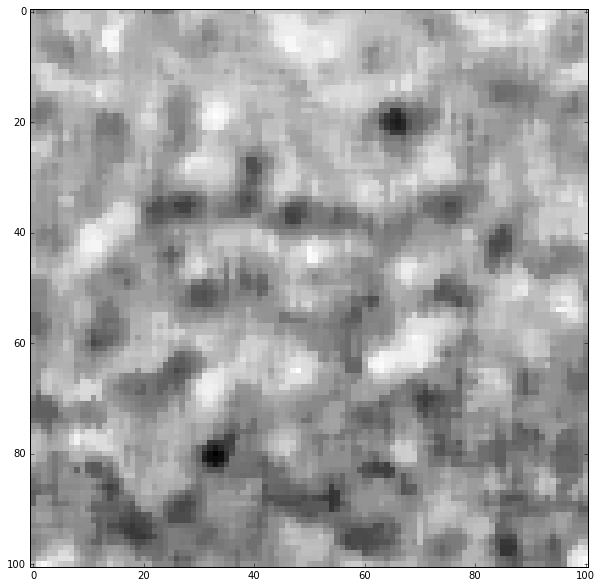

In [6]:
plt.imshow(I[:,:,1])

In [15]:
# This part is done for fine-tuning. Prepare for the txt file needed to write lmdb file.

# # def write_image(I):
# #     for i in range(0,I.shape[2]):
# #         II = (I[:,:,i] - np.mean(I[:,:,i]))/np.mean(I[:,:,i])
# #         # II = np.dstack((np.dstack((II,II)),II))
# #         plt.imsave('/Users/Bato/Documents/caffe/data/phase_contrast/phase_contrast%s.jpeg' % i,II,cmap='gray')
# #     return None
# # write_image(I)


def write_text(a, b, I):

    #a,b is the testing patients number
    p = [0, 192, 387, 507, 677, 842]
    ar = np.zeros((1, 842))
    ar[:,p[a-1]:p[a]] = 1
    ar[:,p[b-1]:p[b]] = 1
    test_set=[]
    train_set=[]
    test_index = np.where(ar==1)[1]
    train_index = np.where(ar==0)[1]
    train_set=open("/Users/Bato/Documents/caffe/data/phase_contrast/trainingset.txt", "w")
    test_set=open("/Users/Bato/Documents/caffe/data/phase_contrast/testingset.txt", "w")
    for j in train_index:
        train_set.write('/phase_contrast'+str(j)+'.jpeg '+str(int(Ans[:,j]))+'\n')
    train_set.close()
    for i in test_index:
        test_set.write('/phase_contrast'+str(i)+'.jpeg '+str(int(Ans[:,i]))+'\n')
    
    train_images = I[:,:,train_index]
    test_images = I[:,:,test_index]
    train_labels = Ans[:,train_index]
    test_labels = Ans[:,test_index]
    
    #np.savetxt('/Users/Bato/Documents/caffe/models/fine_tune_CaffeNet/Tune_fc8_1500iters/testset_label/'+
    #          str(a)+'_'+str(b)+'.txt',test_labels)
    
    return train_images, test_images, train_labels, test_labels

train_I, test_I, train_Ans, test_Ans = write_text(2,4, I)


In [25]:
def read_med_fine_tuning(images):
    
    output_matrix = np.zeros([images.shape[2],4096])
    for i in range(0,images.shape[2]):
        image = images[:,:,i]
        image = (image - np.mean(image))/np.mean(image)
        image_3d = np.dstack((np.dstack((image,image)),image))
        transform_image = transformer.preprocess('data', image_3d)
        print 'Processing the {0} image'.format(i)
        net.blobs['data'].data[...] = transform_image
        output = net.forward()
        feature = net.blobs['fc6'].data[0,:]
#         output_prob = output['prob'][0]#.argmax()
        output_matrix[i,:]= feature#output_prob
        
    return output_matrix

output_matrix = read_med_fine_tuning(test_I)


Processing the 0 image
Processing the 1 image
Processing the 2 image
Processing the 3 image
Processing the 4 image
Processing the 5 image
Processing the 6 image
Processing the 7 image
Processing the 8 image
Processing the 9 image
Processing the 10 image
Processing the 11 image
Processing the 12 image
Processing the 13 image
Processing the 14 image
Processing the 15 image
Processing the 16 image
Processing the 17 image
Processing the 18 image
Processing the 19 image
Processing the 20 image
Processing the 21 image
Processing the 22 image
Processing the 23 image
Processing the 24 image
Processing the 25 image
Processing the 26 image
Processing the 27 image
Processing the 28 image
Processing the 29 image
Processing the 30 image
Processing the 31 image
Processing the 32 image
Processing the 33 image
Processing the 34 image
Processing the 35 image
Processing the 36 image
Processing the 37 image
Processing the 38 image
Processing the 39 image
Processing the 40 image
Processing the 41 image
Pr

In [26]:
np.savetxt('/Users/Bato/Documents/caffe/models/fine_tune_CaffeNet/Tune_fc78_1500iters/test2_4/fc7_matrix_2_4.csv',output_matrix)


In [65]:
# Data preparation for computing the AUC for fine-tuning
from numpy import loadtxt
out1_3 = loadtxt('/Users/Bato/Documents/caffe/models/fine_tune_CaffeNet/Tune_fc78_1500iters/test1_3/pro_matrix_1_3.csv')
out1_4 = loadtxt('/Users/Bato/Documents/caffe/models/fine_tune_CaffeNet/Tune_fc78_1500iters/test1_4/pro_matrix_1_4.csv')
out1_5 = loadtxt('/Users/Bato/Documents/caffe/models/fine_tune_CaffeNet/Tune_fc78_1500iters/test1_5/pro_matrix_1_5.csv')
out2_3 = loadtxt('/Users/Bato/Documents/caffe/models/fine_tune_CaffeNet/Tune_fc78_1500iters/test2_3/pro_matrix_2_3.csv')
out2_4 = loadtxt('/Users/Bato/Documents/caffe/models/fine_tune_CaffeNet/Tune_fc78_1500iters/test2_4/pro_matrix_2_4.csv')
out2_5 = loadtxt('/Users/Bato/Documents/caffe/models/fine_tune_CaffeNet/Tune_fc78_1500iters/test2_5/pro_matrix_2_5.csv')

output_matrixs = [out1_3,out1_4,out1_5,out2_3,out2_4,out2_5]

Ans1_3 = loadtxt('/Users/Bato/Documents/caffe/models/fine_tune_CaffeNet/Tune_fc8_1500iters/testset_label/1_3.txt')
Ans1_4 = loadtxt('/Users/Bato/Documents/caffe/models/fine_tune_CaffeNet/Tune_fc8_1500iters/testset_label/1_4.txt')
Ans1_5 = loadtxt('/Users/Bato/Documents/caffe/models/fine_tune_CaffeNet/Tune_fc8_1500iters/testset_label/1_5.txt')
Ans2_3 = loadtxt('/Users/Bato/Documents/caffe/models/fine_tune_CaffeNet/Tune_fc8_1500iters/testset_label/2_3.txt')
Ans2_4 = loadtxt('/Users/Bato/Documents/caffe/models/fine_tune_CaffeNet/Tune_fc8_1500iters/testset_label/2_4.txt')
Ans2_5 = loadtxt('/Users/Bato/Documents/caffe/models/fine_tune_CaffeNet/Tune_fc8_1500iters/testset_label/2_5.txt')

ans_matrixs = [Ans1_3, Ans1_4, Ans1_5, Ans2_3, Ans2_4,Ans2_5]


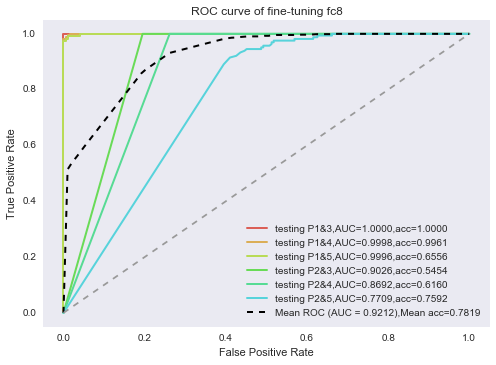

In [67]:
# This part is to computer the AUC when we use fine-tuning.

import sklearn.svm as svm
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from scipy import interp

name = ['P1&3','P1&4','P1&5','P2&3','P2&4','P2&5']
acc = [1.0000,0.9944, 0.7704, 0.5484, 0.6188, 0.7594]
acc7 = [1.0000,0.9961, 0.6556, 0.5454, 0.616, 0.7592 ]
mean_acc = np.mean(acc)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

sns.set_palette('muted')
palette = np.array(sns.color_palette("hls", 10))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i in range(0, len(output_matrixs)):
    fpr, tpr, thresholds = roc_curve(ans_matrixs[i], output_matrixs[i][:,1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2,c=palette[i],
             label='testing %s,AUC=%0.4f,acc=%0.4f' %(name[i],roc_auc,acc7[i]))
    
mean_tpr /= len(output_matrixs)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of fine-tuning fc8')
plt.legend(loc=4)
plt.grid('off')
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (AUC = %0.4f),Mean acc=%0.4f' % (mean_auc,mean_acc), lw=2)
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

plt.savefig('/Users/Bato/Dropbox/tsne_python_5.25/Feature/CaffeNet/fine-tuning/fc78/AUC.png')


In [16]:
# This part is to generate off-the-shell CNN features. 

def read_med_off_the_shell(images):
    
    feat_matrix = np.zeros((images.shape[2],4096))
    for i in range(0, images.shape[2]):
        image = images[:,:,i]
        image = (image - np.mean(image))/np.mean(image)
        image_3d = np.dstack((np.dstack((image,image)),image))
        transform_image = transformer.preprocess('data', image_3d)
        print 'Processing the {0} image'.format(i)
        net.blobs['data'].data[...] = transform_image
        output = net.forward()
        feature = net.blobs['fc6'].data[0,:]
        # feat_matrix[i, :] = np.mean(np.mean(feature, axis=1),axis=1)
        feat_matrix[i,:] = feature
    
    return feat_matrix

feature_matrix = read_med_off_the_shell(I)
np.savetxt('/Users/Bato/Dropbox/tsne_python_5.25/Feature/CaffeNet/fine-tuning/OFF-the-shell/test1_3_fc6.csv',feature_matrix,delimiter=",")


Processing the 0 image
Processing the 1 image
Processing the 2 image
Processing the 3 image
Processing the 4 image
Processing the 5 image
Processing the 6 image
Processing the 7 image
Processing the 8 image
Processing the 9 image
Processing the 10 image
Processing the 11 image
Processing the 12 image
Processing the 13 image
Processing the 14 image
Processing the 15 image
Processing the 16 image
Processing the 17 image
Processing the 18 image
Processing the 19 image
Processing the 20 image
Processing the 21 image
Processing the 22 image
Processing the 23 image
Processing the 24 image
Processing the 25 image
Processing the 26 image
Processing the 27 image
Processing the 28 image
Processing the 29 image
Processing the 30 image
Processing the 31 image
Processing the 32 image
Processing the 33 image
Processing the 34 image
Processing the 35 image
Processing the 36 image
Processing the 37 image
Processing the 38 image
Processing the 39 image
Processing the 40 image
Processing the 41 image
Pr

In [17]:
# Split the whole feature matrix into training/testing sets patient-wise. 
feature_matrix =np.loadtxt('/Users/Bato/Dropbox/tsne_python_5.25/Feature/CaffeNet/fine-tuning/OFF-the-shell/test1_3/test1_3_fc6.csv',delimiter=",")
# feature_matrix =np.loadtxt('/Users/Bato/Dropbox/tsne_python_5.25/Feature/inception3/off-the-shelf/mix1/mix1.csv',delimiter=",")

def split_matrix_to_patient(feature_matrix):
    
    p1 = np.concatenate((feature_matrix[0:192,:], Ans.T[0:192]),axis=1)
    p2 = np.concatenate((feature_matrix[192:387,:], Ans.T[192:387]),axis=1)
    p3 = np.concatenate((feature_matrix[387:507,:], Ans.T[387:507]),axis=1)
    p4 = np.concatenate((feature_matrix[507:677,:], Ans.T[507:677]),axis=1)
    p5 = np.concatenate((feature_matrix[677:,:], Ans.T[677:]),axis=1)

    tr1 = np.concatenate((p2,p4,p5), axis=0)
    tr2 = np.concatenate((p2,p3,p5), axis=0)
    tr3 = np.concatenate((p2,p3,p4), axis=0)
    tr4 = np.concatenate((p1,p4,p5), axis=0)
    tr5 = np.concatenate((p1,p3,p5), axis=0)
    tr6 = np.concatenate((p1,p3,p4), axis=0)

    t1 = np.concatenate((p1,p3),axis=0)
    t2 = np.concatenate((p1,p4),axis=0)
    t3 = np.concatenate((p1,p5),axis=0)
    t4 = np.concatenate((p2,p3),axis=0)
    t5 = np.concatenate((p2,p4),axis=0)
    t6 = np.concatenate((p2,p5),axis=0)

    return tr1, tr2, tr3, tr4, tr5, tr6, t1, t2, t3, t4, t5, t6

tr1, tr2, tr3, tr4, tr5, tr6, t1, t2, t3, t4, t5, t6 = split_matrix_to_patient(feature_matrix)


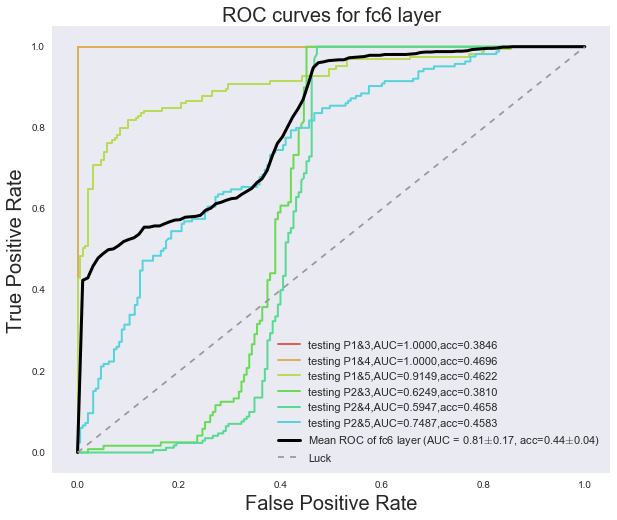

In [19]:
# This part is to compute the AUC when we use off-the-shell CNN features to classify.
# This features are all high-dimensional features. 

import sklearn.svm as svm
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from scipy import interp

sns.set_palette('muted')
palette = np.array(sns.color_palette("hls", 10))

random_state = np.random.RandomState(0)
clf = svm.SVC(gamma=0.001, C=100., probability=True, random_state=random_state)
train = [tr1,tr2,tr3,tr4,tr5,tr6]
test = [t1,t2,t3,t4,t5,t6]
name = ['P1&3','P1&4','P1&5','P2&3','P2&4','P2&5']

mean_tpr3 = 0.0
mean_fpr3 = np.linspace(0, 1, 100)
mean_accuracy = []
std_AUC = []

for i,val in enumerate(train):
    
    clf.fit(train[i][:,:-1],np.ravel(train[i][:,-1:]))

    probas = clf.predict_proba(test[i][:,:-1])
    fpr, tpr, thresholds = roc_curve(test[i][:,-1:], probas[:,1])
    mean_tpr3 += interp(mean_fpr3, fpr, tpr)
    mean_tpr3[0] = 0.0
    roc_auc = auc(fpr, tpr)
    std_AUC.append(roc_auc)
    auccracy = clf.score(test[i][:,:-1], test[i][:,-1:])
    mean_accuracy.append(auccracy)
    plt.plot(fpr, tpr, lw=2,c=palette[i],
             label='testing %s,AUC=%0.4f,acc=%0.4f' % (name[i],roc_auc,auccracy))

mpl.rc('figure',figsize=(15,8))
mean_tpr3 /= len(train)
mean_tpr3[-1] = 1.0
mean_auc3 = auc(mean_fpr3, mean_tpr3)
std_accuracy = np.std(mean_accuracy)
std_AUC = np.std(std_AUC)
mean_accuracy = np.sum(mean_accuracy)/len(mean_accuracy)
# plt.plot(mean_fpr1, mean_tpr1, 'k:',
#         label='Mean ROC of $Caffe_6$ (AUC = %0.2f)' % mean_auc1, lw=3,c=palette[0])
# plt.plot(mean_fpr, mean_tpr, 'k-.',
#          label='Mean ROC of $Caffe_5$ (AUC = %0.2f)' % mean_auc, lw=3, c=palette[1])
plt.plot(mean_fpr3, mean_tpr3, 'k-',
         label='Mean ROC of fc6 layer (AUC = %0.2f$\pm$%0.2f, acc=%0.2f$\pm$%0.2f)' % (mean_auc3,std_AUC,mean_accuracy,std_accuracy), lw=3, c='black')

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.title('ROC curves for fc6 layer',fontsize=20)
plt.legend(loc=4,prop={'size':11})
plt.grid('off')
plt.savefig('/Users/Bato/Dropbox/tsne_python_5.25/Feature/CaffeNet/fine-tuning/OFF-the-shell/test1_3/fc6/fc6-AUC.png')
plt.show()


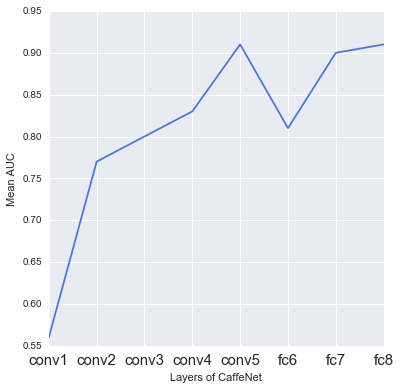

In [139]:
layers = ['conv1','conv2','conv3','conv4','conv5','fc6','fc7','fc8']
x = np.arange(len(layers))
mean_auc = [0.56, 0.77, 0.80, 0.83, 0.91, 0.81, 0.90, 0.91]

mpl.rc('xtick',labelsize=15)
mpl.rc('figure',figsize = (6,6))
plt.xticks(x, layers)
plt.plot(x, mean_auc)
plt.xlabel('Layers of CaffeNet')
plt.ylabel('Mean AUC')
plt.savefig('/Users/Bato/Dropbox/tsne_python_5.25/Feature/CaffeNet/all_mean_auc.png')
plt.show()
